In [28]:
import sys
sys.path.insert(0,'../../../../sib/')
sys.path.insert(0,'../../lib/')
#import sib
import pandas as pd
import numpy as np
import analysis_utils

In [29]:
name_folder_data = "data/"
root_folder_data = "./"
folder_data = root_folder_data + name_folder_data
file_contacts_name = folder_data +  "contacts.csv.gz"
file_obs_name = folder_data +  "obs.tar.gz"

In [30]:
## Loads contacts lists and partial observations

In [31]:
lambda_ = 0.04 #probability of infection
mu = 1./12 #rate of recovery

In [32]:
contacts_df = pd.read_csv(file_contacts_name, dtype={
                                         "i":np.int,
                                        "j":np.int,
                                        "t":np.int,
                                        "lambda":np.float,
                                                })

# time must start from zero
assert(contacts_df["t"].iloc[0] == 0)
# default lambda is already 0.04 for all contacts
contacts_df["lambda"] = lambda_
contacts = list(contacts_df.to_records(index=False))
tot_contacts = len(contacts);
N = contacts_df.loc[:,"i":"j"].max().max() + 1
t_max = contacts_df.loc[:,"t"].max()
print(f"number of individuals: {N}")
print(f"number of unique contacts: {tot_contacts}")

number of individuals: 10000
number of unique contacts: 8901638


## Load true configurations

In [33]:
state_final_true = folder_data +  "gd_OpenABM.txt.gz"
true_conf_df = pd.read_csv(state_final_true, header=None, dtype='Int64', sep=' ')
true_conf = true_conf_df.to_numpy()[:,:-1].transpose()
print("True configuration at final time:")
print (f"I+R = {sum(true_conf[-1]>0)}")
print (f"seeds = {sum(true_conf[0]>0)}")

True configuration at final time:
I+R = 8367
seeds = 5


# Run BP on lists of observations

In [50]:
obs_list = [
]
import tarfile

with tarfile.open(file_obs_name, "r:*") as tar:
    csv_path = tar.getnames()[0]
    for csv_path in tar.getnames():
        if csv_path.endswith('.csv'):
            obs_list.append(pd.read_csv(tar.extractfile(csv_path), dtype={"s":np.int, "i":np.int, "t_test":np.int}).sort_values(by=['t_test'])[["i", "s", "t_test"]])

In [51]:
obs_list[0]

,i,s,t_test
0,2374,0,5
19,2807,1,5
18,824,1,5
17,1885,1,5
16,5651,1,5
...,...,...,...
381,1885,2,24
380,5175,0,24
398,7181,1,24
388,4321,0,24


In [54]:
import analysis_utils

def plot_results(obs_item, observations, t_last_time, ax, n1 = 100, text = ""):
    ax[0].margins(x=0)
    t = t_last_time
    events_I = analysis_utils.events_list(t, 
                      observations, 
                      true_conf, 
                      check_fn = analysis_utils.check_fn_I)
    
    with tarfile.open("./data/MF_d7.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        assert(csv_path[-5]==str(obs_item))
        df = pd.read_csv(tar.extractfile(csv_path), header=0, sep=" ")
        probas_I_MF_allS = pd.read_csv(tar.extractfile(csv_path))
        probas_I_MF_allS = dict(zip(probas_I_MF_allS.node, probas_I_MF_allS.p_I))

    with tarfile.open("./data/DMP.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        probas_I_DMP_allS = pd.read_csv(tar.extractfile(csv_path))
        probas_I_DMP_allS = dict(zip(probas_I_DMP_allS.node, probas_I_DMP_allS.p_I))

    with tarfile.open("./data/random.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        probas_I_random = pd.read_csv(tar.extractfile(csv_path))
        probas_I_random = dict(zip(probas_I_random.node, probas_I_random["count"]))
    
    with tarfile.open("./data/random.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        probas_I_random = pd.read_csv(tar.extractfile(csv_path))
        probas_I_random = dict(zip(probas_I_random.node, probas_I_random["count"]))
    
    with tarfile.open("./data/BP.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        probas_I_BP = pd.read_csv(tar.extractfile(csv_path))
        probas_I_BP = dict(zip(probas_I_BP.index, probas_I_BP.p_I))

    with tarfile.open("./data/Greedy.tar.gz", "r:*") as tar:
        csv_path = list(n for n in tar.getnames() if n.endswith('.csv'))[obs_item]
        score_tracing = pd.read_csv(tar.extractfile(csv_path))
        score_tracing = dict(zip(score_tracing.node, score_tracing["score"]))
    
    
    x_mf,y_mf,a_mf, sortl_mf = analysis_utils.roc_curve(probas_I_MF_allS, 
                                              events_I, 
                                              ranker = lambda x: x)
    x_dmp,y_dmp,a_dmp, sortl_dmp = analysis_utils.roc_curve(probas_I_DMP_allS, 
                                              events_I, 
                                              ranker = lambda x: x)
    x_r,y_r,a_r, sortl_r = analysis_utils.roc_curve(probas_I_random, 
                                              events_I, 
                                              ranker = lambda x: x)
    x,y,a, sortl = analysis_utils.roc_curve(probas_I_BP, 
                                              events_I, 
                                              ranker = lambda x: x)
    
    x_greedy, y_greedy, a_greedy, sortl_greedy = analysis_utils.roc_curve(score_tracing,
                                                                   events_I,
                                                                   ranker = lambda x: x)
    ax[0].plot(x, y, label=f"BP area: {a:.3f}")
    ax[0].plot(x_mf, y_mf, label=f"MF area: {a_mf:.3f}")
    ax[0].plot(x_dmp, y_dmp, label=f"DMP area: {a_dmp:.3f}")
    ax[0].plot(x_r, y_r, label=f"Random area: {a_r:.3f}")
    ax[0].plot(x_greedy, y_greedy, label=f"Greedy area: {a_greedy:.3f}")

    ax[0].legend()
    ax[0].plot([0,x[-1]],[0,y[-1]])
    
    ax[1].plot(y[0:n1], label=f"BP area: {a:.3f}")
    ax[1].plot(y_mf[0:n1], label=f"MF area: {a_mf:.3f}")
    ax[1].plot(y_dmp[0:n1], label=f"DMP area: {a_dmp:.3f}")
    ax[1].plot(y_r[0:n1], label=f"Random area: {a_r:.3f}")
    ax[1].plot(y_greedy[0:n1], label=f"Greedy area: {a_greedy:.3f}")
    ax[1].plot(range(n1),range(n1))
        
    ax[0].text(x[10]*1.5, y[-1]/1.1, text, fontsize=12)

    #ax[0].legend()


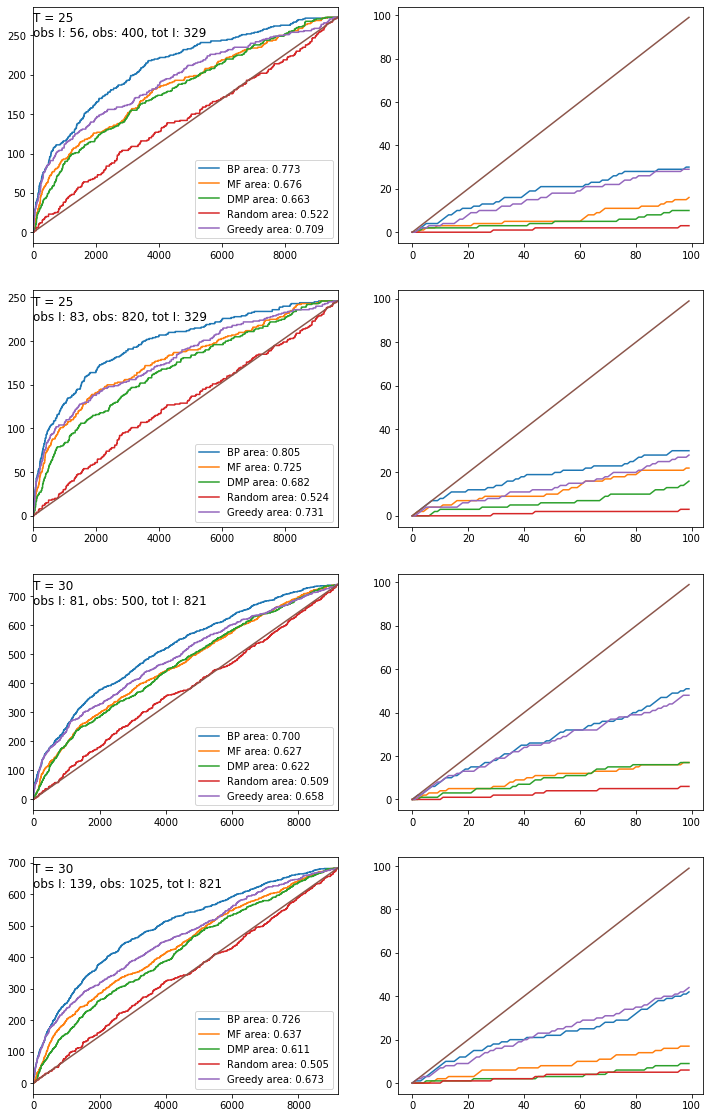

In [55]:
from matplotlib import pyplot as plt

num_i = 4
fig, axs = plt.subplots(num_i,2,
                   figsize=(12, 5*num_i))

for obs_item in range(num_i):
    
    obs_df = obs_list[obs_item]
    #obs_df = obs_df[(obs_df["t_test"] <= time_max_c)]
    t_last_time = obs_df.t_test.max() + 1
    observations = [(i,-1,0) for i in range(N)]
    observations += list(obs_df.to_records(index=False))
    observations += [(i,-1,t_last_time) for i in range(N)]
    I_obs = len(set(obs_df[obs_df["s"] == 1].values[:,0]))
    text = f"T = {t_last_time}\n"
    text += f"obs I: {I_obs}, "
    text += f"obs: {len(obs_df)}, "
    tot_I = str(sum(true_conf[t_last_time] == 1))
    text += f"tot I: {tot_I} "
    #fig.suptitle('Horizontally stacked subplots')
    plot_results(obs_item, observations, t_last_time, axs[obs_item], text = text)